# Method: LSTM 
# Dataset: KS Equation, L = 60
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("KS, L = 60", "../../data/ks60", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 240)
Test size: (90000, 240)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 240)
Test output size: (100, 400, 240)


# 2. LSTM Implementation

In [9]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = sigmoid(forget_gate * c + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = sigmoid(forget_gate * cell + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [10]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.35):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 50):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if (best_mse < early_stopping_baseline or mse_val > 1000) and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [11]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [54]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [55]:
nn_size = 100

In [56]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 4.11 | Train loss = 0.0064813 | Val loss =  66.6103058
Epoch 20: Time taken = 4.47 | Train loss = 0.0031514 | Val loss =  16.0651379
Epoch 30: Time taken = 4.02 | Train loss = 0.0022848 | Val loss =  3.6499240
Epoch 40: Time taken = 4.15 | Train loss = 0.0018554 | Val loss =  6.1148973
Epoch 50: Time taken = 3.61 | Train loss = 0.0015958 | Val loss =  16.3614712
Epoch 52: Time taken = 3.66 | Train loss = 0.0015458 | Val loss =  2.4941008
Epoch 60: Time taken = 3.65 | Train loss = 0.0014118 | Val loss =  2.2334368
Epoch 70: Time taken = 3.63 | Train loss = 0.0012813 | Val loss =  3.6031630
Epoch 80: Time taken = 4.41 | Train loss = 0.0011678 | Val loss =  2.1889508
Epoch 90: Time taken = 3.67 | Train loss = 0.0010792 | Val loss =  30.9359303
Epoch 100: Time taken = 3.84 | Train loss = 0.0010036 | Val loss =  2.6890802
Epoch 101: Time taken = 3.92 | Train loss = 0.0009937 | Val loss =  2.0327227
Epoch 110: Time taken = 3.98 | Train loss = 0.0

In [57]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.81


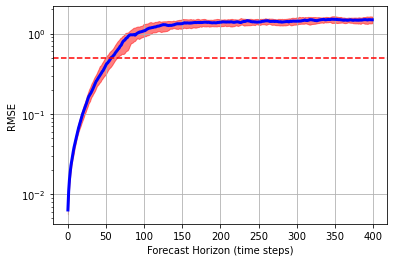

It takes around t = 14.25 for mean error to exceed 0.5


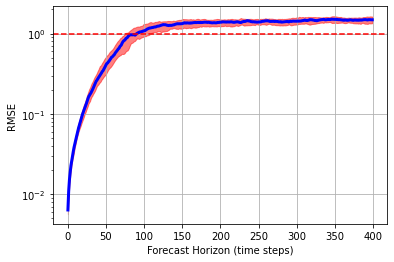

It takes around t = 22.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.104
Median NRMSE at t = 0.5: 0.409
Median NRMSE at t = 1: 1.085
Median NRMSE at t = 2: 1.382
Median NRMSE at t = 3: 1.426


In [58]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = 0.25)
res_single.plot_rmse(error_thresh = 1., dt = 0.25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [59]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [60]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.48 | Train loss = 0.0030925 | Val loss =  161.8687286
Epoch 20: Time taken = 4.65 | Train loss = 0.0018174 | Val loss =  25.2352848
Epoch 30: Time taken = 4.50 | Train loss = 0.0010918 | Val loss =  2.7256217
Epoch 40: Time taken = 4.52 | Train loss = 0.0007965 | Val loss =  1.7276562
Epoch 50: Time taken = 4.49 | Train loss = 0.0006092 | Val loss =  1.7444663
Epoch 55: Time taken = 4.50 | Train loss = 0.0005699 | Val loss =  1.5597508
Epoch 60: Time taken = 4.49 | Train loss = 0.0005534 | Val loss =  1.6015176
Epoch 68: Time taken = 4.54 | Train loss = 0.0004308 | Val loss =  1.5127667
Epoch 69: Time taken = 4.51 | Train loss = 0.0004607 | Val loss =  1.4914367
Epoch 70: Time taken = 4.54 | Train loss = 0.0004448 | Val loss =  1.5738782
Epoch 80: Time taken = 4.70 | Train loss = 0.0003904 | Val loss =  1.4977794
Epoch 88: Time taken = 4.52 | Train loss = 0.0003591 | Val loss =  1.4719551
Epoch 90: Time taken = 4.66 | Train loss = 0.00034

In [61]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 1.13


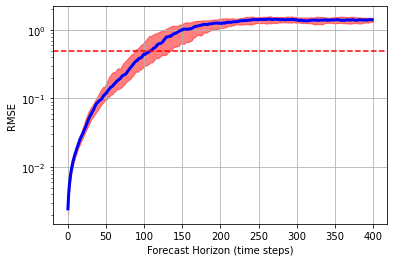

It takes around t = 27.25 for mean error to exceed 0.5


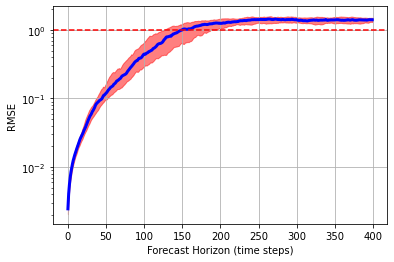

It takes around t = 37.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.032
Median NRMSE at t = 0.5: 0.119
Median NRMSE at t = 1: 0.445
Median NRMSE at t = 2: 1.247
Median NRMSE at t = 3: 1.410


In [80]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = 0.25)
res_single.plot_rmse(error_thresh = 1., dt = 0.25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [63]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [64]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 10.27 | Train loss = 0.0025954 | Val loss =  10.3719473
Epoch 20: Time taken = 10.07 | Train loss = 0.0010619 | Val loss =  1.6551528
Epoch 30: Time taken = 10.21 | Train loss = 0.0005822 | Val loss =  1.5971330
Epoch 40: Time taken = 10.17 | Train loss = 0.0003985 | Val loss =  1.5615236
Epoch 50: Time taken = 10.06 | Train loss = 0.0002814 | Val loss =  1.6143714
Epoch 52: Time taken = 10.26 | Train loss = 0.0002958 | Val loss =  1.5190057
Epoch 54: Time taken = 10.06 | Train loss = 0.0002825 | Val loss =  1.5036222
Epoch 60: Time taken = 10.08 | Train loss = 0.0002459 | Val loss =  1.5003684
Epoch 62: Time taken = 10.04 | Train loss = 0.0002082 | Val loss =  1.4671363
Epoch 69: Time taken = 10.02 | Train loss = 0.0002396 | Val loss =  1.4378161
Epoch 70: Time taken = 10.02 | Train loss = 0.0001746 | Val loss =  1.5995852
Epoch 80: Time taken = 10.04 | Train loss = 0.0001816 | Val loss =  1.5390371
Epoch 87: Time taken = 10.04 | Train los

In [65]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 1.68


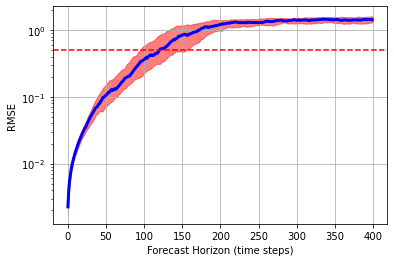

It takes around t = 30.00 for mean error to exceed 0.5


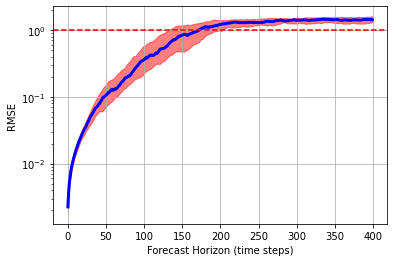

It takes around t = 43.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.030
Median NRMSE at t = 0.5: 0.106
Median NRMSE at t = 1: 0.362
Median NRMSE at t = 2: 1.214
Median NRMSE at t = 3: 1.398


In [85]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [70]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [200, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [71]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 18.16 | Train loss = 0.0024087 | Val loss =  7.5813189
Epoch 20: Time taken = 18.15 | Train loss = 0.0008911 | Val loss =  1.6830249
Epoch 30: Time taken = 36.30 | Train loss = 0.0005064 | Val loss =  1.5346038
Epoch 40: Time taken = 20.81 | Train loss = 0.0003420 | Val loss =  1.5015359
Epoch 50: Time taken = 18.15 | Train loss = 0.0002224 | Val loss =  1.6218710
Epoch 53: Time taken = 18.17 | Train loss = 0.0002705 | Val loss =  1.4298187
Epoch 60: Time taken = 18.16 | Train loss = 0.0002037 | Val loss =  1.5909660
Epoch 70: Time taken = 18.16 | Train loss = 0.0001518 | Val loss =  1.5999233
Epoch 76: Time taken = 18.20 | Train loss = 0.0001584 | Val loss =  1.4285209
Epoch 77: Time taken = 18.18 | Train loss = 0.0001654 | Val loss =  1.4268975
Epoch 80: Time taken = 18.31 | Train loss = 0.0001818 | Val loss =  1.4869361
Epoch 88: Time taken = 18.27 | Train loss = 0.0001135 | Val loss =  1.3906033
Epoch 90: Time taken = 18.26 | Train loss

In [72]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 2.38


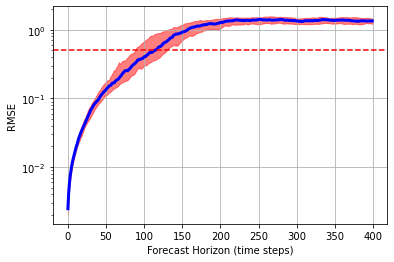

It takes around t = 28.50 for mean error to exceed 0.5


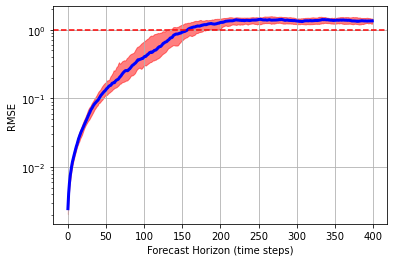

It takes around t = 39.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.038
Median NRMSE at t = 0.5: 0.135
Median NRMSE at t = 1: 0.404
Median NRMSE at t = 2: 1.283
Median NRMSE at t = 3: 1.349


In [87]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [89]:
nn_size = 1000
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [90]:
L_forecast_train = 4; L_past = 1

In [91]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.13 | Train loss = 0.0008955 | Val loss =  249.5345917
Epoch 20: Time taken = 4.16 | Train loss = 0.0004855 | Val loss =  31.6283741
Epoch 30: Time taken = 4.20 | Train loss = 0.0003716 | Val loss =  3.3900304
Epoch 40: Time taken = 4.20 | Train loss = 0.0002986 | Val loss =  1.9310677
Epoch 50: Time taken = 4.20 | Train loss = 0.0002387 | Val loss =  1.7175977
Epoch 54: Time taken = 4.20 | Train loss = 0.0002184 | Val loss =  1.6751553
Epoch 56: Time taken = 4.20 | Train loss = 0.0002197 | Val loss =  1.6593702
Epoch 58: Time taken = 4.20 | Train loss = 0.0002138 | Val loss =  1.6460843
Epoch 59: Time taken = 4.23 | Train loss = 0.0002185 | Val loss =  1.5683290
Epoch 60: Time taken = 4.25 | Train loss = 0.0002369 | Val loss =  1.7018811
Epoch 69: Time taken = 4.20 | Train loss = 0.0002046 | Val loss =  1.5188999
Epoch 70: Time taken = 4.23 | Train loss = 0.0002038 | Val loss =  1.6017340
Epoch 78: Time taken = 4.22 | Train loss = 0.00018

In [92]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 1.40


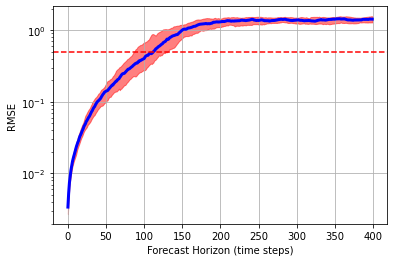

It takes around t = 28.25 for mean error to exceed 0.5


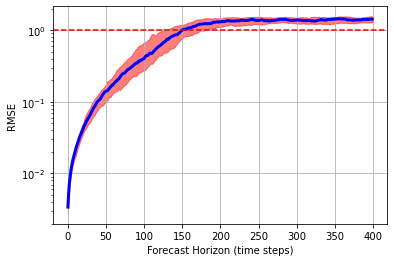

It takes around t = 37.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.042
Median NRMSE at t = 0.5: 0.141
Median NRMSE at t = 1: 0.402
Median NRMSE at t = 2: 1.307
Median NRMSE at t = 3: 1.380


In [93]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [94]:
L_forecast_train = 4; L_past = 4

In [95]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 6.84 | Train loss = 0.0007246 | Val loss =  475.4093933
Epoch 20: Time taken = 6.82 | Train loss = 0.0002871 | Val loss =  63.8831482
Epoch 30: Time taken = 6.84 | Train loss = 0.0001463 | Val loss =  3.9340494
Epoch 40: Time taken = 6.83 | Train loss = 0.0001222 | Val loss =  2.7324822
Epoch 50: Time taken = 6.81 | Train loss = 0.0000971 | Val loss =  1.6897132
Epoch 52: Time taken = 6.83 | Train loss = 0.0000970 | Val loss =  1.6161152
Epoch 55: Time taken = 6.84 | Train loss = 0.0000844 | Val loss =  1.6080811
Epoch 56: Time taken = 6.82 | Train loss = 0.0000831 | Val loss =  1.5670274
Epoch 57: Time taken = 6.83 | Train loss = 0.0000800 | Val loss =  1.5623386
Epoch 60: Time taken = 6.83 | Train loss = 0.0000852 | Val loss =  1.6081280
Epoch 63: Time taken = 6.82 | Train loss = 0.0000763 | Val loss =  1.5287966
Epoch 70: Time taken = 6.85 | Train loss = 0.0000603 | Val loss =  1.5762239
Epoch 72: Time taken = 6.84 | Train loss = 0.00006

In [96]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 1.43


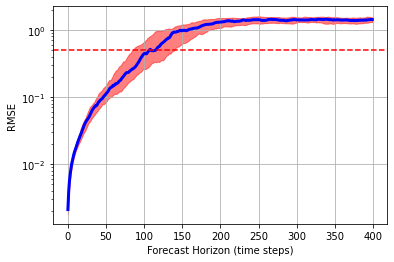

It takes around t = 26.75 for mean error to exceed 0.5


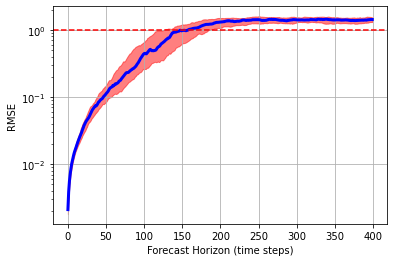

It takes around t = 39.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.035
Median NRMSE at t = 0.5: 0.112
Median NRMSE at t = 1: 0.443
Median NRMSE at t = 2: 1.305
Median NRMSE at t = 3: 1.406


In [97]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [98]:
L_forecast_train = 4; L_past = 8

In [99]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 9.93 | Train loss = 0.0010586 | Val loss =  441.3229675
Epoch 20: Time taken = 9.90 | Train loss = 0.0005380 | Val loss =  101.4149628
Epoch 30: Time taken = 9.88 | Train loss = 0.0001735 | Val loss =  11.6651583
Epoch 40: Time taken = 9.83 | Train loss = 0.0001298 | Val loss =  4.6376562
Epoch 50: Time taken = 13.05 | Train loss = 0.0000943 | Val loss =  2.6882010
Epoch 51: Time taken = 13.16 | Train loss = 0.0000892 | Val loss =  2.6065793
Epoch 57: Time taken = 9.87 | Train loss = 0.0000803 | Val loss =  2.5331357
Epoch 60: Time taken = 9.92 | Train loss = 0.0000817 | Val loss =  2.5067232
Epoch 62: Time taken = 9.91 | Train loss = 0.0000762 | Val loss =  2.3607428
Epoch 64: Time taken = 9.88 | Train loss = 0.0000804 | Val loss =  2.3266346
Epoch 65: Time taken = 9.98 | Train loss = 0.0000725 | Val loss =  2.3126106
Epoch 67: Time taken = 9.91 | Train loss = 0.0000697 | Val loss =  2.2475147
Epoch 70: Time taken = 9.87 | Train loss = 0.0

In [100]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 3.67


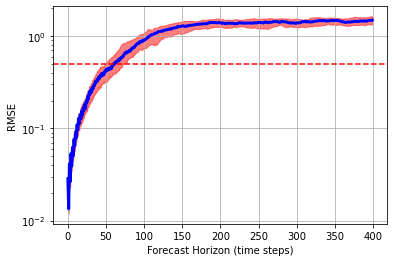

It takes around t = 15.00 for mean error to exceed 0.5


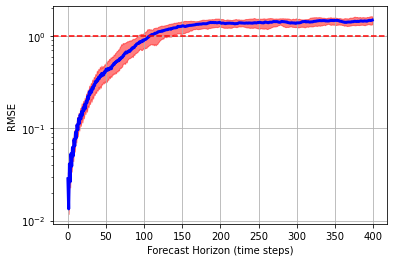

It takes around t = 26.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.168
Median NRMSE at t = 0.5: 0.439
Median NRMSE at t = 1: 0.916
Median NRMSE at t = 2: 1.395
Median NRMSE at t = 3: 1.395


In [101]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [102]:
L_forecast_train = 8; L_past = 1

In [103]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 7.45 | Train loss = 0.0030528 | Val loss =  11.2216711
Epoch 20: Time taken = 7.46 | Train loss = 0.0015144 | Val loss =  1.6620282
Epoch 30: Time taken = 7.42 | Train loss = 0.0009089 | Val loss =  1.5576423
Epoch 40: Time taken = 7.50 | Train loss = 0.0007591 | Val loss =  1.5319656
Epoch 50: Time taken = 7.47 | Train loss = 0.0005301 | Val loss =  1.6477003
Epoch 51: Time taken = 7.49 | Train loss = 0.0006573 | Val loss =  1.4785926
Epoch 60: Time taken = 7.45 | Train loss = 0.0005267 | Val loss =  1.5156609
Epoch 67: Time taken = 7.45 | Train loss = 0.0004902 | Val loss =  1.4712572
Epoch 69: Time taken = 7.53 | Train loss = 0.0005174 | Val loss =  1.4698321
Epoch 70: Time taken = 7.55 | Train loss = 0.0004467 | Val loss =  1.4702541
Epoch 74: Time taken = 7.46 | Train loss = 0.0004445 | Val loss =  1.4631341
Epoch 76: Time taken = 7.48 | Train loss = 0.0004170 | Val loss =  1.4381462
Epoch 80: Time taken = 7.49 | Train loss = 0.0003908

In [104]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.63


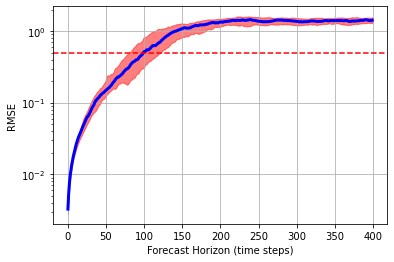

It takes around t = 24.75 for mean error to exceed 0.5


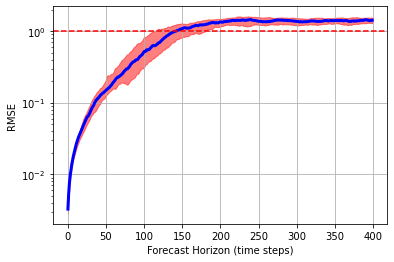

It takes around t = 35.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.047
Median NRMSE at t = 0.5: 0.150
Median NRMSE at t = 1: 0.517
Median NRMSE at t = 2: 1.343
Median NRMSE at t = 3: 1.371


In [105]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [106]:
L_forecast_train = 8; L_past = 4

In [107]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 10.23 | Train loss = 0.0025954 | Val loss =  10.3719473
Epoch 20: Time taken = 10.25 | Train loss = 0.0010619 | Val loss =  1.6551528
Epoch 30: Time taken = 10.22 | Train loss = 0.0005822 | Val loss =  1.5971330
Epoch 40: Time taken = 10.22 | Train loss = 0.0003985 | Val loss =  1.5615236
Epoch 50: Time taken = 10.22 | Train loss = 0.0002814 | Val loss =  1.6143714
Epoch 52: Time taken = 10.28 | Train loss = 0.0002958 | Val loss =  1.5190057
Epoch 54: Time taken = 10.23 | Train loss = 0.0002825 | Val loss =  1.5036222
Epoch 60: Time taken = 10.21 | Train loss = 0.0002459 | Val loss =  1.5003684
Epoch 62: Time taken = 10.23 | Train loss = 0.0002082 | Val loss =  1.4671363
Epoch 69: Time taken = 10.20 | Train loss = 0.0002396 | Val loss =  1.4378161
Epoch 70: Time taken = 10.23 | Train loss = 0.0001746 | Val loss =  1.5995852
Epoch 80: Time taken = 10.20 | Train loss = 0.0001816 | Val loss =  1.5390371
Epoch 87: Time taken = 10.18 | Train los

In [108]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 1.45


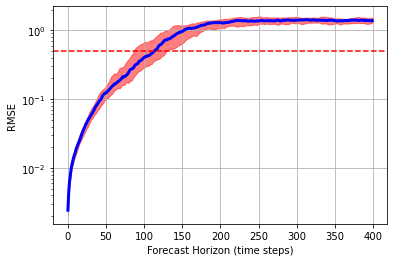

It takes around t = 28.50 for mean error to exceed 0.5


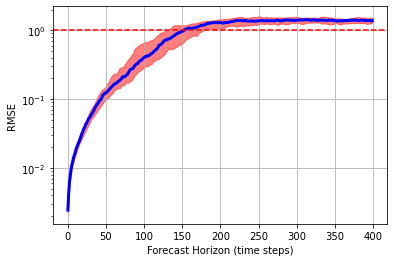

It takes around t = 38.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.035
Median NRMSE at t = 0.5: 0.124
Median NRMSE at t = 1: 0.402
Median NRMSE at t = 2: 1.288
Median NRMSE at t = 3: 1.403


In [109]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [110]:
L_forecast_train = 8; L_past = 8

In [113]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 12.97 | Train loss = 0.0023610 | Val loss =  18.2388229
Epoch 20: Time taken = 12.95 | Train loss = 0.0014727 | Val loss =  1.7489672
Epoch 30: Time taken = 12.97 | Train loss = 0.0010297 | Val loss =  1.6169139
Epoch 40: Time taken = 12.99 | Train loss = 0.0004624 | Val loss =  1.6023952
Epoch 50: Time taken = 13.04 | Train loss = 0.0002786 | Val loss =  1.5904166
Epoch 55: Time taken = 13.07 | Train loss = 0.0003009 | Val loss =  1.4675039
Epoch 56: Time taken = 13.13 | Train loss = 0.0002890 | Val loss =  1.4634458
Epoch 60: Time taken = 13.00 | Train loss = 0.0002525 | Val loss =  1.5614398
Epoch 61: Time taken = 13.02 | Train loss = 0.0002566 | Val loss =  1.4618466
Epoch 67: Time taken = 13.01 | Train loss = 0.0001960 | Val loss =  1.4569269
Epoch 68: Time taken = 13.02 | Train loss = 0.0002570 | Val loss =  1.4053171
Epoch 70: Time taken = 13.03 | Train loss = 0.0001913 | Val loss =  1.5535195
Epoch 76: Time taken = 12.96 | Train los

In [114]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 1.65


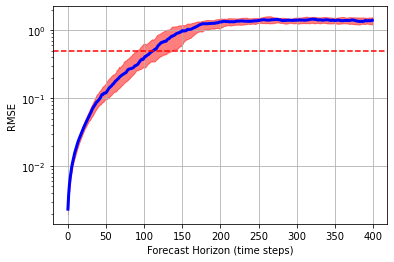

It takes around t = 28.00 for mean error to exceed 0.5


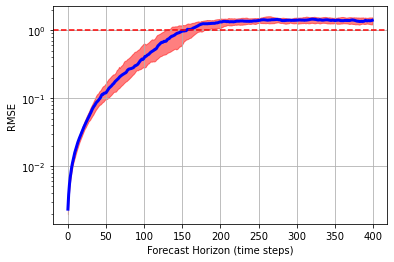

It takes around t = 39.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.036
Median NRMSE at t = 0.5: 0.120
Median NRMSE at t = 1: 0.391
Median NRMSE at t = 2: 1.326
Median NRMSE at t = 3: 1.399


In [115]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [116]:
L_forecast_train = 16; L_past = 1

In [117]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 14.27 | Train loss = 0.0149871 | Val loss =  1.7114927
Epoch 20: Time taken = 14.28 | Train loss = 0.0071075 | Val loss =  1.6357861
Epoch 30: Time taken = 14.25 | Train loss = 0.0046733 | Val loss =  1.5803398
Epoch 40: Time taken = 14.27 | Train loss = 0.0031596 | Val loss =  1.5940084
Epoch 50: Time taken = 14.30 | Train loss = 0.0024958 | Val loss =  1.5337646
Epoch 53: Time taken = 14.25 | Train loss = 0.0025360 | Val loss =  1.5095326
Epoch 60: Time taken = 14.19 | Train loss = 0.0022033 | Val loss =  1.4889017
Epoch 70: Time taken = 14.22 | Train loss = 0.0020626 | Val loss =  1.5391843
Epoch 76: Time taken = 14.21 | Train loss = 0.0018383 | Val loss =  1.4885663
Epoch 79: Time taken = 14.22 | Train loss = 0.0015509 | Val loss =  1.4512132
Epoch 80: Time taken = 14.23 | Train loss = 0.0017500 | Val loss =  1.5261270
Epoch 86: Time taken = 14.20 | Train loss = 0.0016219 | Val loss =  1.4452204
Epoch 90: Time taken = 14.22 | Train loss

In [118]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 1.56


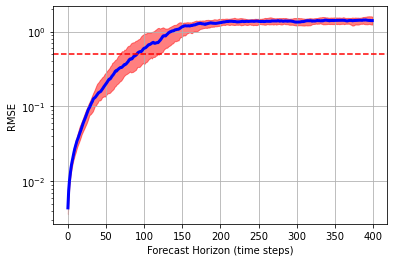

It takes around t = 22.75 for mean error to exceed 0.5


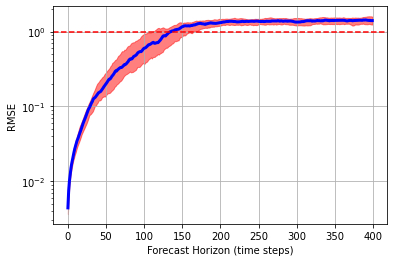

It takes around t = 34.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.060
Median NRMSE at t = 0.5: 0.201
Median NRMSE at t = 1: 0.599
Median NRMSE at t = 2: 1.317
Median NRMSE at t = 3: 1.337


In [119]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [120]:
L_forecast_train = 16; L_past = 4

In [121]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 17.03 | Train loss = 0.0122655 | Val loss =  1.7772813
Epoch 20: Time taken = 17.01 | Train loss = 0.0058550 | Val loss =  1.5553980
Epoch 30: Time taken = 17.02 | Train loss = 0.0034137 | Val loss =  1.5618109
Epoch 40: Time taken = 17.04 | Train loss = 0.0024123 | Val loss =  1.5575321
Epoch 50: Time taken = 17.13 | Train loss = 0.0014852 | Val loss =  1.6366799
Epoch 60: Time taken = 17.06 | Train loss = 0.0013191 | Val loss =  1.4615753
Epoch 61: Time taken = 17.07 | Train loss = 0.0012801 | Val loss =  1.4493260
Epoch 66: Time taken = 17.05 | Train loss = 0.0010892 | Val loss =  1.4377232
Epoch 69: Time taken = 17.06 | Train loss = 0.0010748 | Val loss =  1.3866580
Epoch 70: Time taken = 17.07 | Train loss = 0.0011036 | Val loss =  1.5182923
Epoch 80: Time taken = 17.07 | Train loss = 0.0009182 | Val loss =  1.4550319
Epoch 81: Time taken = 17.06 | Train loss = 0.0009118 | Val loss =  1.3324366
Epoch 90: Time taken = 17.08 | Train loss

In [122]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 1.51


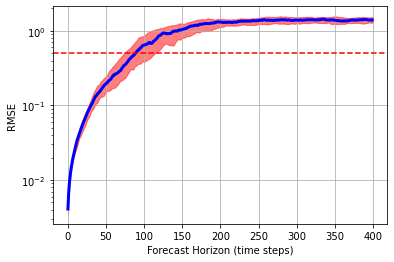

It takes around t = 22.25 for mean error to exceed 0.5


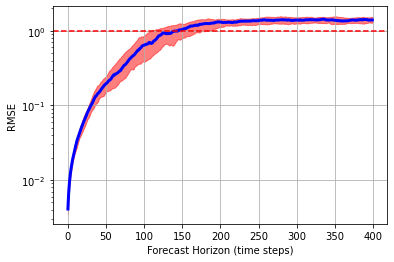

It takes around t = 35.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.058
Median NRMSE at t = 0.5: 0.196
Median NRMSE at t = 1: 0.641
Median NRMSE at t = 2: 1.314
Median NRMSE at t = 3: 1.391


In [123]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [124]:
L_forecast_train = 16; L_past = 8

In [125]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 19.96 | Train loss = 0.0118562 | Val loss =  1.6890380
Epoch 20: Time taken = 19.96 | Train loss = 0.0057900 | Val loss =  1.6151179
Epoch 30: Time taken = 19.96 | Train loss = 0.0036010 | Val loss =  1.6231831
Epoch 40: Time taken = 19.92 | Train loss = 0.0029218 | Val loss =  1.5273460
Epoch 50: Time taken = 19.92 | Train loss = 0.0020546 | Val loss =  1.5915267
Epoch 60: Time taken = 19.92 | Train loss = 0.0014290 | Val loss =  1.4721955
Epoch 68: Time taken = 19.87 | Train loss = 0.0012294 | Val loss =  1.4645178
Epoch 69: Time taken = 19.87 | Train loss = 0.0011565 | Val loss =  1.4488592
Epoch 70: Time taken = 19.92 | Train loss = 0.0010158 | Val loss =  1.4298043
Epoch 72: Time taken = 19.89 | Train loss = 0.0010183 | Val loss =  1.4099350
Epoch 80: Time taken = 19.88 | Train loss = 0.0009984 | Val loss =  1.4818498
Epoch 90: Time taken = 20.00 | Train loss = 0.0008155 | Val loss =  1.4574373
Epoch 99: Time taken = 19.94 | Train loss

In [126]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 1.60


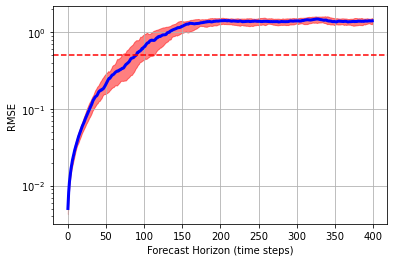

It takes around t = 22.50 for mean error to exceed 0.5


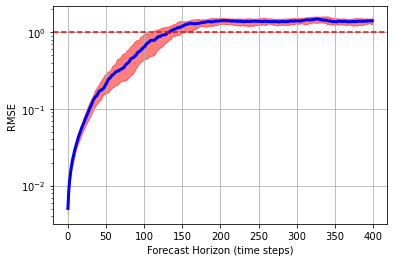

It takes around t = 33.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.063
Median NRMSE at t = 0.5: 0.212
Median NRMSE at t = 1: 0.648
Median NRMSE at t = 2: 1.414
Median NRMSE at t = 3: 1.409


In [127]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 1000  
L_forecast_train = 8  
L_past = 4

In [13]:
nn_size = 1000
L_forecast_train = 8
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [500, 200, 200]  # Number of epochs for each learning rate

In [14]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 100)

Backpropogation start

Epoch 10: Time taken = 10.36 | Train loss = 0.0026126 | Val loss =  10.6652737
Epoch 20: Time taken = 10.45 | Train loss = 0.0010630 | Val loss =  1.7924974
Epoch 30: Time taken = 10.40 | Train loss = 0.0005880 | Val loss =  1.6002008
Epoch 40: Time taken = 10.53 | Train loss = 0.0004562 | Val loss =  1.5539256
Epoch 50: Time taken = 10.48 | Train loss = 0.0003147 | Val loss =  1.4912030
Epoch 53: Time taken = 10.45 | Train loss = 0.0003022 | Val loss =  1.4775156
Epoch 55: Time taken = 10.49 | Train loss = 0.0002850 | Val loss =  1.4751245
Epoch 56: Time taken = 10.54 | Train loss = 0.0002835 | Val loss =  1.4616743
Epoch 60: Time taken = 10.48 | Train loss = 0.0002648 | Val loss =  1.5787174
Epoch 70: Time taken = 10.54 | Train loss = 0.0002032 | Val loss =  1.6196434
Epoch 73: Time taken = 10.47 | Train loss = 0.0002103 | Val loss =  1.4575001
Epoch 74: Time taken = 10.47 | Train loss = 0.0002057 | Val loss =  1.4445738
Epoch 80: Time taken = 10.48 | Train los

In [15]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.56


In [16]:
save_obj(params, "results/lstm", "best_params.pkl")
save_obj(mean_pred, "results/lstm", "best_mu_preds.pkl")

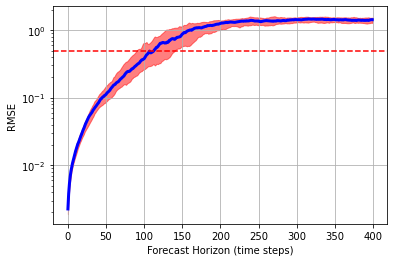

It takes around t = 28.25 for mean error to exceed 0.5


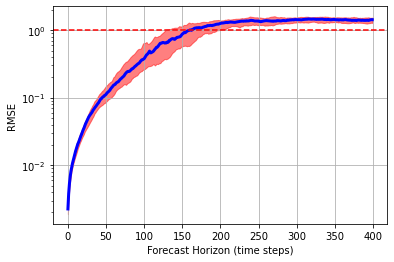

It takes around t = 40.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.033
Median NRMSE at t = 0.5: 0.112
Median NRMSE at t = 1: 0.379
Median NRMSE at t = 2: 1.259
Median NRMSE at t = 3: 1.431


In [17]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [12]:
nn_size = 1000
_, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [13]:
params = load_obj("results/lstm/best_params.pkl")

In [14]:
mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "lstm_pred.pkl")

Testing complete. Time taken: 2.87


In [10]:
mean_pred = load_obj("results/lstm_pred.pkl")

In [11]:
total_lyapunov_time_pred = 100 / KS_LT # Amount of Lyapunov Time in Test set

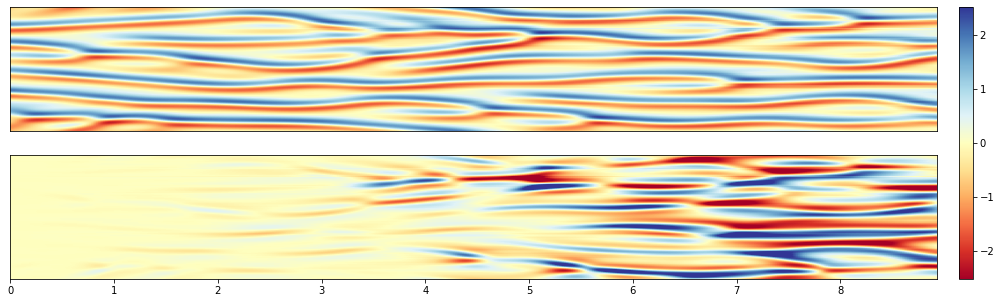

In [12]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "ks_lstm", pred_only=True)

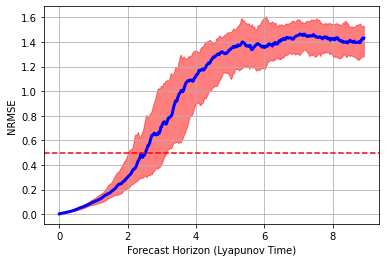

It takes around 2.52 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.038
Median NRMSE at 1.0 Lyapunov Time: 0.097
Median NRMSE at 2.0 Lyapunov Time: 0.296
Median NRMSE at 5.0 Lyapunov Time: 1.338


In [18]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "ks")
res_single.plot_rmse(save_name = "Figure3-4b_LSTM_Prediction_Horizon")
print()
res_single.get_loss()